<a href="https://colab.research.google.com/github/Zeusfire2058/code_stuff_woo/blob/master/Lorenz_63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.4 MB/s eta 0:00:00


Generating reference solution 0/1000
Generating reference solution 100/1000
Generating reference solution 200/1000
Generating reference solution 300/1000
Generating reference solution 400/1000
Generating reference solution 500/1000
Generating reference solution 600/1000
Generating reference solution 700/1000
Generating reference solution 800/1000
Generating reference solution 900/1000
Compiling model...
Building feed-forward neural network...
'build' took 0.042384 s

'compile' took 0.403786 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.71e+02]    [2.70e+02]    [9.96e-01]    
1000      [5.13e+00]    [1.53e+01]    [2.37e-01]    
2000      [9.15e-01]    [1.66e+01]    [2.47e-01]    
3000      [3.62e-01]    [1.77e+01]    [2.55e-01]    
4000      [1.88e-01]    [1.83e+01]    [2.59e-01]    
5000      [1.10e-01]    [1.86e+01]    [2.61e-01]    

Best model at step 5000:
  train loss: 1.10e-01
  test loss: 1.86e+01
  test metric: [2.61e-01]

'train' took 

ValueError: x and y must have same first dimension, but have shapes (200,) and (199,)

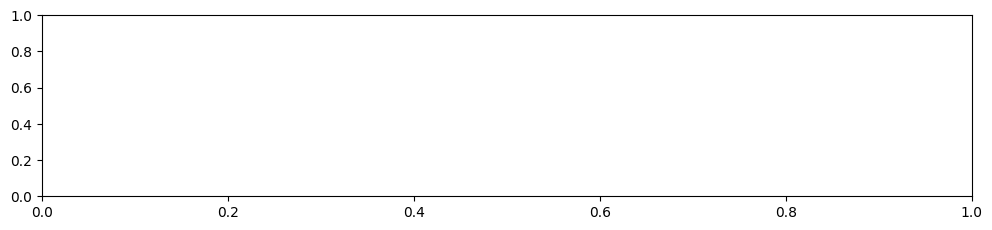

In [28]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#time variable for linespace
num_reference_solutions = 1000  # N_s
final_time = 20  # T, when to stop simulation (in seconds)
observations_per_second = 10
observation_times = np.linspace(0, final_time, final_time * observations_per_second) # {t_n}

class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]


class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]
#Make Training Data
def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 5.0  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    final_time = 20  # T, when to stop simulation (in seconds)
    observations_per_second = 10
    observation_times = np.linspace(0, final_time, final_time * observations_per_second) # {t_n}

    input_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution {i}/{num_reference_solutions}")

        # Generate random initial conditions
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)

        # Simulate true system
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], observation_times)

        # Create observations (x-component only)
        x_observed = np.column_stack((observation_times, true_solution[:, 0])) # I_M(u^i(t_k))

        # Simulate nudged system
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observation_times, args=(x_observed, mu)) # W^i(t_k)

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observation_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)
    '''
    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()
    '''
    return input_data, output_data

# Run the simulation
original, nudged = simulate_lorenz_with_nudging()


############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

#define Lorenz 63 Model
X_train = original
Y_train = nudged
data = dde.data.DataSet(X_train, Y_train, X_test = original , y_test = original[:, [0 , 1, 2]])
net = dde.nn.FNN([4] + [50] * 3 + [3], "tanh", "Glorot normal")

model_63 = dde.Model(data, net)
model_63.compile("adam", lr=0.001, metrics = ["l2 relative error"])
losshistory, train_state = model_63.train(iterations=5000)

#################################################################################
#Create test data for graphs
def test_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 5.0  # Nudging parameter

    input_test_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar, observed x) @ time t
    output_test_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar) @ time t+1

    for i in range(1):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution {i}/{1}")

        # Generate random initial conditions
        x0, y0, z0 = np.random.normal(loc=0, scale=50, size=3)

        # Simulate true system
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], observation_times)

        # Create observations (x-component only)
        x_observed = np.column_stack((observation_times, true_solution[:, 0])) # I_M(u^i(t_k))

        # Simulate nudged system
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observation_times, args=(x_observed, mu)) # W^i(t_k)

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observation_times) -  1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_test_samples.append(input_pair)
            output_test_samples.append(next_state)

    # Convert to numpy arrays
    input_test_data = np.array(input_test_samples)
    output_test_data = np.array(output_test_samples)

    return input_test_data, output_test_data

# Run the test simulation for graphs
original_test, nudged_test = test_lorenz_with_nudging()

output_63 = model_63.predict(original_test)
x_63 = output_63[:, 0]
y_63 = output_63[:, 1]
z_63 = output_63[:, 2]
t = observation_times



# Plot results
plt.figure(figsize=(12, 8))

# Plot x components
plt.subplot(3, 1, 1)
plt.plot(t, original_test[:, 0], 'b-', label='Original x')
#plt.plot(t, nudged_test[:, 0], 'r-', label = 'Nudging x')
plt.plot(t, x_63, 'g--', label='Estimated x')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()

# Plot y components
plt.subplot(3, 1, 2)
plt.plot(t, original_test[:, 1], 'b-', label='Original y')
#plt.plot(t, nudged_test[:, 1], 'r-', label = 'Nudging y')
plt.plot(t, y_63, 'g--', label='Estimated y')
plt.ylabel('y')
plt.legend()

# Plot z components
plt.subplot(3, 1, 3)
plt.plot(t, original_test[:, 2], 'b-', label='Original z')
#plt.plot(t, nudged_test[:, 2], 'r-', label = 'Nudging z')
plt.plot(t, z_63, 'g--', label='Estimated z')
plt.ylabel('z')
plt.xlabel('Time')
plt.legend()

plt.suptitle('Lorenz 63 System: Original, Nudging, and Estimated Solutions')
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(12, 8))

# Plot x components
plt.subplot(3, 1, 1)
plt.plot(t, original[:, 0], 'b-', label='Original x')
plt.plot(t, xyz_pred[:, 0], 'r--', label='Estimated x')
plt.ylabel('x')
plt.legend()

# Plot y components
plt.subplot(3, 1, 2)
plt.plot(t, original[:, 1], 'b-', label='Original y')
plt.plot(t, xyz_pred[:, 1], 'r--', label='Estimated y')
plt.ylabel('y')
plt.legend()

# Plot z components
plt.subplot(3, 1, 3)
plt.plot(t, original[:, 2], 'b-', label='Original z')
plt.plot(t, xyz_pred[:, 2], 'r--', label='Estimated z')
plt.ylabel('z')
plt.xlabel('Time')
plt.legend()

plt.suptitle('Lorenz 63 System: Original vs Estimated Solutions')
plt.show()